In [14]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
import tensorflow
from glob import glob

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!unzip '/content/drive/MyDrive/Images.zip'

Archive:  /content/drive/MyDrive/Images.zip
replace Images/001a54188dfb6bae2060cc30d2b8ca57.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Images/001acc59adbf97e1685acbe710176a44.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
Image_path = '../content/Images'

In [18]:
tensorflow.random.set_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)
tensorflow.random.set_seed(2)
np.random.seed(1)


In [19]:
data = glob(os.path.join(Image_path,'*.jpg'))

In [20]:
len(data),data[0]

(913, '../content/Images/1a6f233c6e510a1ec53e31ff2267f9b0.jpg')

In [21]:
HEIGHT=256
WIDTH=256
      
def ExtractInput(path):
    X_img=[]
    y_img=[]
    for im in path:
        try:
            img = cv2.imread(im)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            #img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
    
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128

            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [22]:
X_,y_ = ExtractInput(data) # Data-preprocessing

In [23]:
X_.shape,y_.shape

((913, 256, 256), (913, 256, 256, 2))

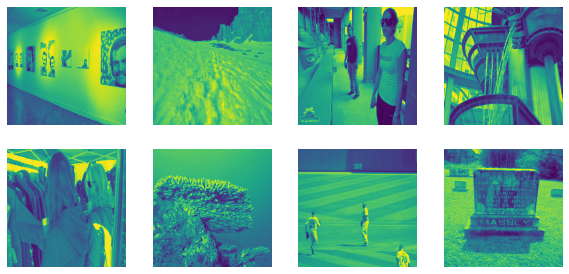

In [24]:
plt.figure(figsize=(10,10))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(X_[i])

In [25]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16, (3, 3), padding = 'same', strides = 1)(in_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(32, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size = (2, 2), padding = 'same')(model_)
    
    model_ = Conv2D(64, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size = (2, 2), padding = 'same')(model_)
    
    model_ = Conv2D(128, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64, (3, 3), padding = 'same', strides = 1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2, (3, 3), activation = 'tanh', padding = 'same', strides = 1)(model_)

    return model_

In [26]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)


In [27]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 4640        leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [29]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
Model_Colourization.fit(GenerateInputs(X_,y_),epochs=5,verbose=1,steps_per_epoch=38,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))



Epoch 1/5
38/38 [==============================] - 88s 2s/step - loss: 0.5656
Epoch 2/5
38/38 [==============================] - 87s 2s/step - loss: 0.0135
Epoch 3/5
38/38 [==============================] - 87s 2s/step - loss: 0.0148
Epoch 4/5
38/38 [==============================] - 87s 2s/step - loss: 0.0100
Epoch 5/5
38/38 [==============================] - 86s 2s/step - loss: 0.0161


In [30]:

TestImagePath=data[0]
TestImagePath

'../content/Images/1a6f233c6e510a1ec53e31ff2267f9b0.jpg'

In [41]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped


In [42]:
ImagePath=TestImagePath

# plt.imshow(cv2.imread(ImagePath))
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*110
Prediction=Prediction.reshape(256,256,2)

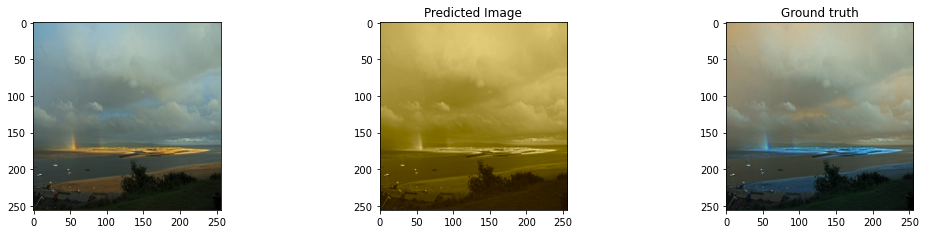

In [48]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img_1 = cv2.imread(TestImagePath)
img_1 = cv2.resize(img_1, (256, 256))
img = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
# plt.imshow(img_)
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

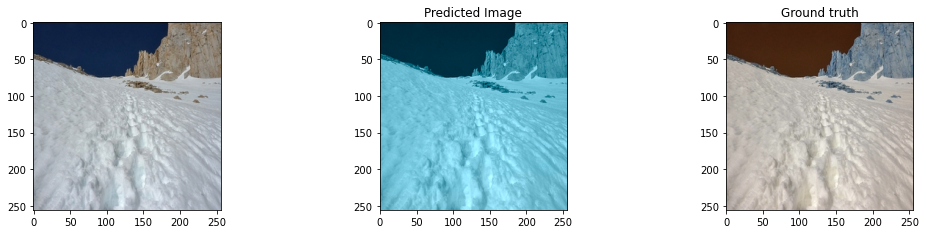

In [49]:
TestImagePath=data[1]
ImagePath=data[1]
# plt.imshow(cv2.imread(ImagePath))
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*110
Prediction=Prediction.reshape(256,256,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img_1 = cv2.imread(TestImagePath)
img_1 = cv2.resize(img_1, (256, 256))
img = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
# plt.imshow(img_)
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)